# Lab 3 - Feature Importance and Global Surrogates
In this lab we will use Feature Permutation to determine the feature importance of built models, both classification and regression models.

First, you are asked to implement feature permutation by yourself on a neural network classifier trained on a breast cancer dataset, then to compare your permutation scores to the prebuilt methods that exist.
Then, the same is to be performed on a neural network regressor.

Finally, you are to build a surrogate model to try and explain/interpret how a support vector machine (SVM) model makes its decisions by training a decision tree based on the predictions from the SVM.

## Installation for Google Colab
Run the cell below to install the required packages to use the notebook in Google Colab.

You might get an error saying Google Colab requires Pandas 1.5.1. Ignore that and just restart the session from the menu above: **Runtime** -> **Restart Session**.

After you installed the packages and restarted the session, you can continue with the lab.

**Remember, if you take a longer break or divide your work over several days you will have to reinstall the packages by running the cell below again and restarting the session.**

In [1]:
%pip install -U scikit-learn==1.4.1.post1 shap==0.45.0 lime==0.2.0.1 graphviz==0.20.2 dtreeviz==2.2.2 eli5==0.13.0 xgboost==2.0.3 pandas==2.2.1 seaborn==0.13.2 numpy==1.26.4

  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.3
    Uninstalling numpy-1.26.3:
      Successfully uninstalled numpy-1.26.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dowhy 0.10.1 requires causal-learn>=0.1.3.0, which is not installed.
cvxpy 1.4.2 requires pybind11, which is not installed.
dowhy 0.10.1 requires cython<0.30.0,>=0.29.32, but you have cython 3.0.7 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


## Package import

In [2]:
import pandas as pd
import numpy as np

from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

import pickle

## Upload the built models to Colab
If you are using Colab, run the cell below and then press the button "Choose files". Navigate to the **model_bc.pkl** and **model_diab.pkl** files that you downloaded from the lab page on Blacboard, and upload them. We will use them later on the lab.


In [ ]:
from google.colab import files
uploaded = files.upload()

# Feature Importance by Permutation
Identify and analyse the feature importance by permuting the values in a column by column basis.

## Classifier
Here, we provide a black box model using a Multi Layer Perceptron classifier that has been trained on the breast cancer dataset. Your task is to identify which features are most important for the model using feature permutation.

In [4]:
data = load_breast_cancer()
X = pd.DataFrame(data['data'])
y = data['target']
X.columns = data['feature_names']
X=(X-X.min())/(X.max()-X.min())

X.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

Load the black box model.

In [5]:
f = open('model_bc.pkl', 'rb')
clf = pickle.load(f)
f.close()

/Users/rena/anaconda3/envs/explainableai/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.4.1.post1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/rena/anaconda3/envs/explainableai/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.4.1.post1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


If loading the black box model does not work, run the cell below to train the model yourself. It might take a while...

In [ ]:
# ONLY RUN IF YOU COULD NOT UPLOAD THE BLACK BOX MODELS

parameters = {'solver': ['lbfgs'], 'max_iter': [2000], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(1,20), 'random_state':[42]}
clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)
clf.fit(X_train, y_train)
clf = clf.best_estimator_
with open('model_bc.pkl', 'wb') as out:
    pickle.dump(clf, out)

### Todo
Implement feature permutation for the **clf** model and use the models built in scorer. Remember to permute the features multiple times as the results will vary depending on how the data is permuted. Present the results as the average result with standard deviations for each feature.

In [6]:
# Implement feature permutation

import numpy as np
import pickle
from sklearn.metrics import get_scorer
from sklearn.model_selection import train_test_split

# Load trained model
with open('model_bc.pkl', 'rb') as inp:
    clf = pickle.load(inp)

# Define the evaluation function using the model's built-in scorer
def evaluate_model(model, X, y, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    baseline_score = model.score(X, y)
    scores = []
    for column in X.columns:
        X_permuted = X.copy()
        X_permuted[column] = np.random.permutation(X_permuted[column])
        score = model.score(X_permuted, y)
        scores.append(baseline_score - score)
    return scores

# Calculate feature importance manually
n_repeats = 30  # Number of shuffles
importance_scores = np.zeros((n_repeats, len(X_test.columns)))

for i in range(n_repeats):
    scores = evaluate_model(clf, X_test, y_test, random_state=42 + i)
    importance_scores[i] = scores

importance_means = importance_scores.mean(axis=0)
importance_std = importance_scores.std(axis=0)

# Print manual results
print("Manual Feature Importances:")
for feature, mean, std in zip(X_test.columns, importance_means, importance_std):
    print(f"{feature}: {mean:.3f} ± {std:.3f}")


Manual Feature Importances:
mean radius: -0.001 ± 0.003
mean texture: -0.002 ± 0.003
mean perimeter: -0.001 ± 0.003
mean area: -0.001 ± 0.002
mean smoothness: -0.007 ± 0.007
mean compactness: 0.004 ± 0.010
mean concavity: 0.015 ± 0.012
mean concave points: 0.032 ± 0.011
mean symmetry: -0.002 ± 0.004
mean fractal dimension: -0.004 ± 0.006
radius error: 0.009 ± 0.009
texture error: 0.003 ± 0.008
perimeter error: 0.004 ± 0.004
area error: 0.004 ± 0.005
smoothness error: -0.001 ± 0.005
compactness error: -0.007 ± 0.004
concavity error: -0.000 ± 0.001
concave points error: 0.001 ± 0.002
symmetry error: -0.004 ± 0.006
fractal dimension error: -0.006 ± 0.006
worst radius: 0.031 ± 0.014
worst texture: 0.052 ± 0.014
worst perimeter: 0.009 ± 0.008
worst area: 0.015 ± 0.008
worst smoothness: 0.005 ± 0.008
worst compactness: -0.001 ± 0.007
worst concavity: 0.008 ± 0.011
worst concave points: 0.011 ± 0.009
worst symmetry: 0.003 ± 0.009
worst fractal dimension: -0.001 ± 0.003


Of course there already exist implemented functionality to perform feature permutation, for instance with **sklearn**.

See if your own results from feature permutation aligns with the ones produced in the cells below.

In [7]:
y_pred = clf.predict(X_test)
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
        print(f'{X.columns[i]:<19} '
              f'{r.importances_mean[i]:.3f}'
              f' +/- {r.importances_std[i]:.3f}')


worst texture       0.053 +/- 0.012
mean concave points 0.032 +/- 0.014
worst radius        0.031 +/- 0.012
worst concave points 0.017 +/- 0.011
mean concavity      0.015 +/- 0.011
worst concavity     0.014 +/- 0.009
worst area          0.012 +/- 0.010
mean compactness    0.009 +/- 0.010
radius error        0.009 +/- 0.007
worst perimeter     0.009 +/- 0.009
worst smoothness    0.005 +/- 0.009
area error          0.004 +/- 0.004
perimeter error     0.004 +/- 0.005
texture error       0.003 +/- 0.006
worst symmetry      0.002 +/- 0.008
concave points error 0.001 +/- 0.002
concavity error     -0.000 +/- 0.001
mean area           -0.000 +/- 0.001
worst compactness   -0.002 +/- 0.005
smoothness error    -0.002 +/- 0.004
mean symmetry       -0.002 +/- 0.004
mean texture        -0.003 +/- 0.004
mean radius         -0.003 +/- 0.003
worst fractal dimension -0.003 +/- 0.004
mean perimeter      -0.003 +/- 0.003
mean fractal dimension -0.003 +/- 0.006
symmetry error      -0.004 +/- 0.005
mean smo

### Reflection
- What do the results above mean?
- What conclusions/insights can we draw of the model based of off them?

In [ ]:
#Each feature's impact on the predictive accuracy (or another chosen metric) of a machine learning model 
#is assessed by measuring the change in performance caused by randomly shuffling the feature's values. 
#The numbers represent the average change in performance (mean) and the variability of this change across
#multiple repetitions (standard deviation). Features with positive importance scores imply that randomizing 
#the feature's values led to a decrease in model performance. This suggests that the feature is important 
#for making accurate predictions because the original, unshuffled order of the values contains useful information 
#that the model relies on. Features with negative importance scores suggest that shuffling the feature's 
#data either did not affect or slightly improved the model's performance. This indicates that the model does
#not rely on this feature for making accurate predictions, or possibly that the original order may contain 
#misleading or noisy information.

## Regression
The same task as before lies ahead of you, but in this instance we instead look towards the Multi Layer Perceptron for regression. This model has been trained on a diabetes dataset where the target variable is the disease progression.

In [8]:
data = load_diabetes()
X = pd.DataFrame(data['data'])
y = data['target']
X.columns = data['feature_names']

X.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

Load the black box model.

In [9]:
f = open('model_diab.pkl', 'rb')
clf = pickle.load(f)
f.close()

/Users/rena/anaconda3/envs/explainableai/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.4.1.post1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


If loading the black box model does not work, run the cell below to train the model yourself. It might take a while...

In [ ]:
# ONLY RUN IF YOU COULD NOT UPLOAD THE BLACK BOX MODELS
parameters = {'solver': ['lbfgs'], 'max_iter': [2000], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(1,20), 'random_state':[42]}
clf = GridSearchCV(MLPRegressor(), parameters, n_jobs=-1)
clf.fit(X_train, y_train)
clf = clf.best_estimator_
# Stores the produced model for the students' later use
with open('model_diab.pkl', 'wb') as out:
    pickle.dump(clf, out)


### Todo
Implement feature permutation for the **clf** model and use the models built in scorer. Remember to permute the features multiple times as the results will vary. Present the results as the average result with standard deviations for each feature.

In [10]:
#Implement feature permutation
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error, r2_score

# Load trained model
with open('model_diab.pkl', 'rb') as inp:
    clf = pickle.load(inp)


baseline_score = clf.score(X_test, y_test)  # Using the model's built-in scorer

# Initialize arrays to store the results
importances = np.zeros((X_test.shape[1], 30))  # 30 permutations per feature

# Function to calculate score
def calculate_score(model, X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)  # Replace with appropriate scorer if different

for i in range(30):  # Number of permutations
    for col_idx in range(X_test.shape[1]):  # For each feature
        X_permuted = X_test.copy()
        # Shuffle the column
        X_permuted.iloc[:, col_idx] = np.random.permutation(X_permuted.iloc[:, col_idx].values)
        permuted_score = calculate_score(clf, X_permuted, y_test)
        # Store the decrease in score (because higher score means better performance)
        importances[col_idx, i] = baseline_score - permuted_score

# Calculate mean and standard deviation of importances
importance_means = np.mean(importances, axis=1)
importance_stds = np.std(importances, axis=1)

# Print the results
print("Feature Importances:")
feature_names = X_test.columns
for feature, mean, std in zip(feature_names, importance_means, importance_stds):
    print(f"{feature}: {mean:.3f} ± {std:.3f}")


Feature Importances:
age: -0.000 ± 0.001
sex: 0.050 ± 0.018
bmi: 0.219 ± 0.046
bp: 0.080 ± 0.030
s1: 0.283 ± 0.066
s2: 0.149 ± 0.031
s3: 0.001 ± 0.001
s4: 0.036 ± 0.012
s5: 0.395 ± 0.044
s6: -0.003 ± 0.002


In [11]:
r = permutation_importance(clf, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
        print(f"{X.columns[i]:<19} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


s5                  0.398 +/- 0.048
s1                  0.286 +/- 0.046
bmi                 0.217 +/- 0.042
s2                  0.148 +/- 0.029
bp                  0.079 +/- 0.027
sex                 0.056 +/- 0.020
s4                  0.029 +/- 0.009
s3                  0.001 +/- 0.001
age                 -0.002 +/- 0.002
s6                  -0.003 +/- 0.001


### Reflection
- What do the results above mean?
- What conclusions can we draw of the model based of off them?

In [ ]:
#I explained above the meaning of the values in permutation feature importance.
#Features such as s5, s1, bmi, s2, and bp have positive permutation importance scores. 
#This implies that when these features are shuffled, the model's performance significantly decreases.
#These features are thus important to the model for making accurate predictions, indicating
#strong dependence on these predictors. Features like age and s6 have negative or near-zero importance scores,
#suggesting that shuffling these features slightly improves or does not significantly change the model's performance. 
#This indicates that these features do not contribute valuable predictive information and may be irrelevant 
#or redundant given other features in the model.

**to be filled by student**

# Global Surrogate
In this part of the lab you will be tasked to train Support Vector Machines (SVMs) on two given datasets. The SVMs are then to be subject for the global surrogate approach, where you will train CART models on the input data and the output from the SVMs.

## Classification

Here, you create a SVM. THe SVM is then used to predict data which is then fed into the CART algorithm to train.
This mimics the model from the SVM into the cart model, which is cheaper to use.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

data = load_iris()
X = pd.DataFrame(data['data'])
X.columns = data['feature_names']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)


In [13]:
clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [14]:
from sklearn.metrics import r2_score
surrogate = DecisionTreeClassifier()
surrogate.fit(X_train, clf.predict(X_train))
y_pred = surrogate.predict(X_test)

r2_score(y_test, y_pred)

1.0

Visualize the tree and try and see how the CART approximates the SVM.

R^2 Score: 1.0


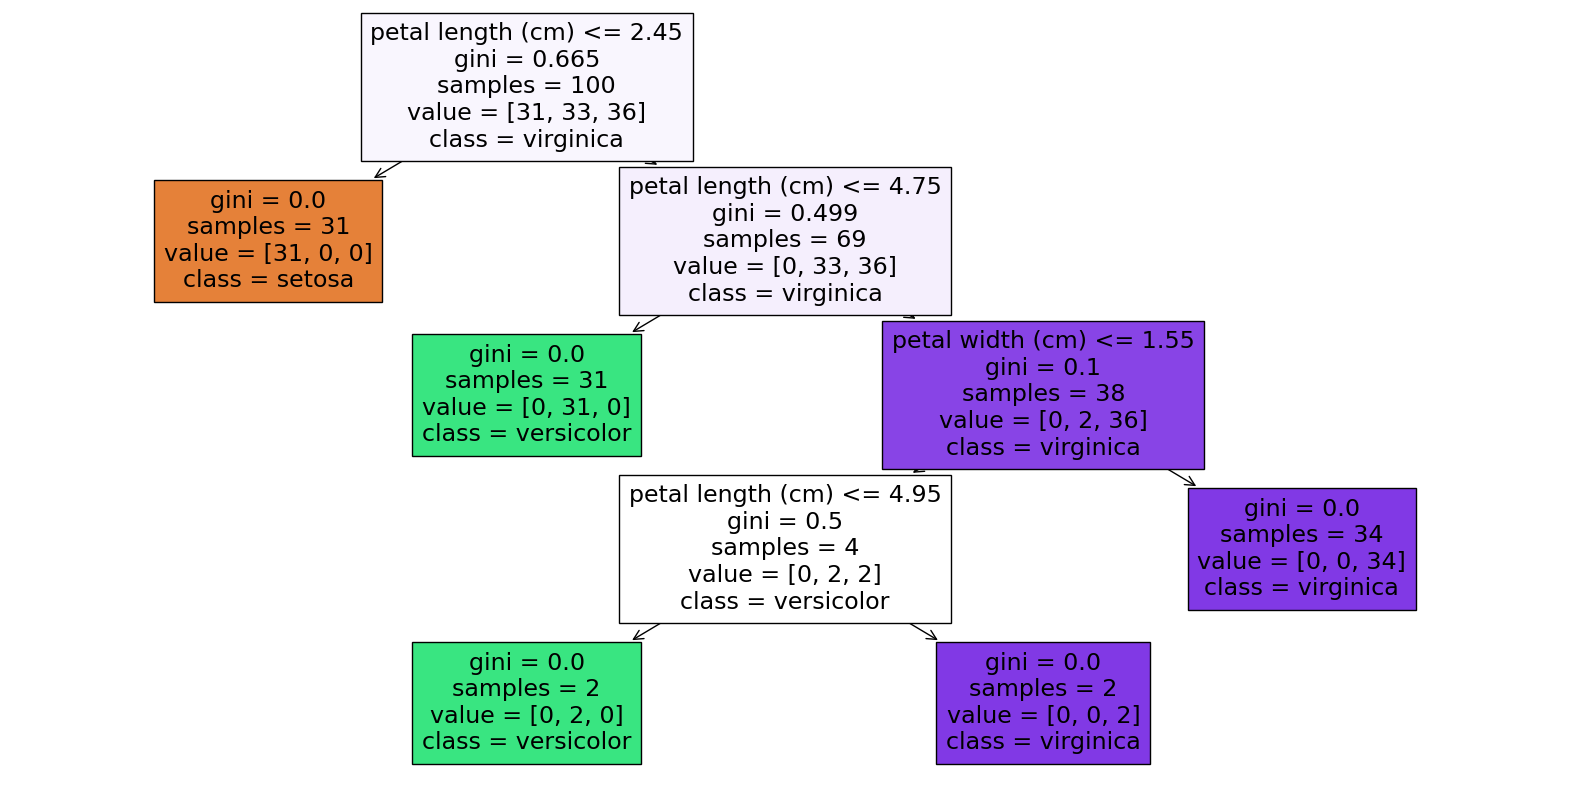

In [15]:
# Visualize tree
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load and split the Iris dataset
data = load_iris()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

# Train the SVC model
clf = SVC()
clf.fit(X_train, y_train)

# Train the surrogate Decision Tree model
surrogate = DecisionTreeClassifier()
surrogate.fit(X_train, clf.predict(X_train))

# Predict and evaluate using r2_score
y_pred = surrogate.predict(X_test)
print(f"R^2 Score: {r2_score(y_test, y_pred)}")

# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(surrogate, filled=True, feature_names=data['feature_names'], class_names=data['target_names'])
plt.show()


F1 Score: 0.98


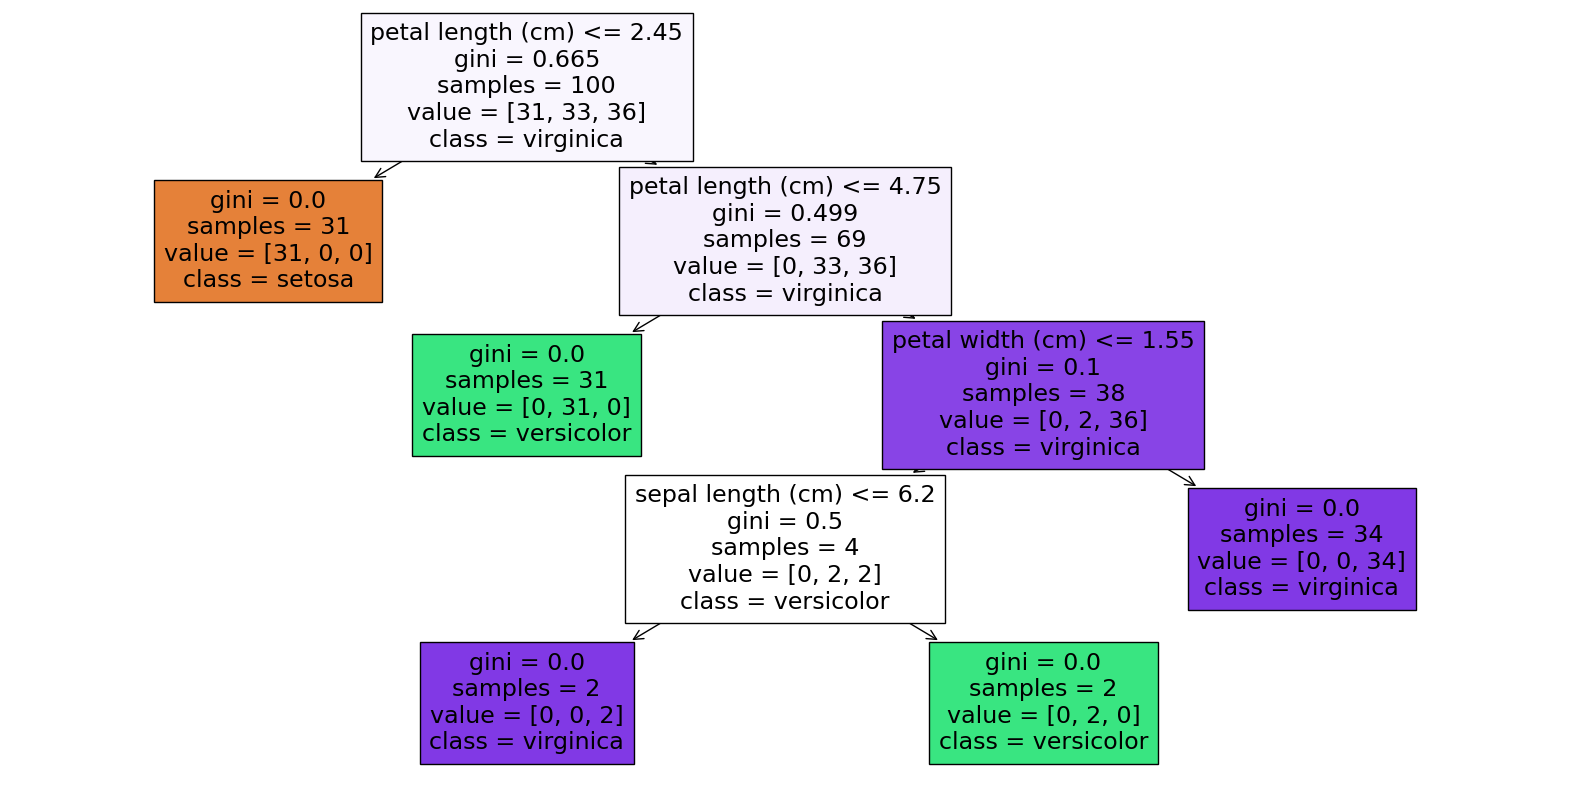

In [16]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Load and split the Iris dataset
data = load_iris()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

# Train the SVC model
clf = SVC()
clf.fit(X_train, y_train)

# Train the surrogate Decision Tree model
surrogate = DecisionTreeClassifier()
surrogate.fit(X_train, clf.predict(X_train))

# Predict and evaluate using f1_score
y_pred = surrogate.predict(X_test)
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(surrogate, filled=True, feature_names=data['feature_names'], class_names=data['target_names'])
plt.show()


* How is the SVM approximated?
* What features give the most importance to the model?
* How does it operate?

In [ ]:
#Model didn't work very well with r2 score, the decisions were overlapping and made little sense.
#With f1score, using a Decision Tree as a surrogate model to approximate the decisions of a Support Vector Machine (SVM), 
#the goal was to capture and simplify the decision boundaries defined by the SVM into a form that can be more easily interpreted.
#The Decision Tree attempts to mimic the decision function of the SVM by learning from the labels predicted by the SVM, 
#rather than the actual ground truth labels. Essentially, the tree maps the same input features to the SVM's predictions.
#In Decision Trees, the importance of a feature is often measured by the amount it decreases the weighted impurity in a tree. 
#A feature used at many splits in a tree that significantly decreases impurity is considered more important.
#The Decision Tree creates a model that makes decisions by asking a series of questions based on feature values. 
#Each internal node in the tree represents a "question" or a "split" on a feature (e.g., is sepal length > 5.0 cm?), 
#directing the data to the left or right child node based on the answer.

**To be filled by student**

## Regression

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

data = load_diabetes()
X = pd.DataFrame(data['data'])
X.columns = data['feature_names']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

In [18]:
clf = SVR()
clf.fit(X_train, y_train)

SVR()

In [19]:
surrogate = DecisionTreeRegressor()
surrogate.fit(X_train, clf.predict(X_train))
y_pred = surrogate.predict(X_test)

r2_score(y_test, y_pred)

0.12186247071453782

Visualize the tree and try and see how the CART approximates the SVR.

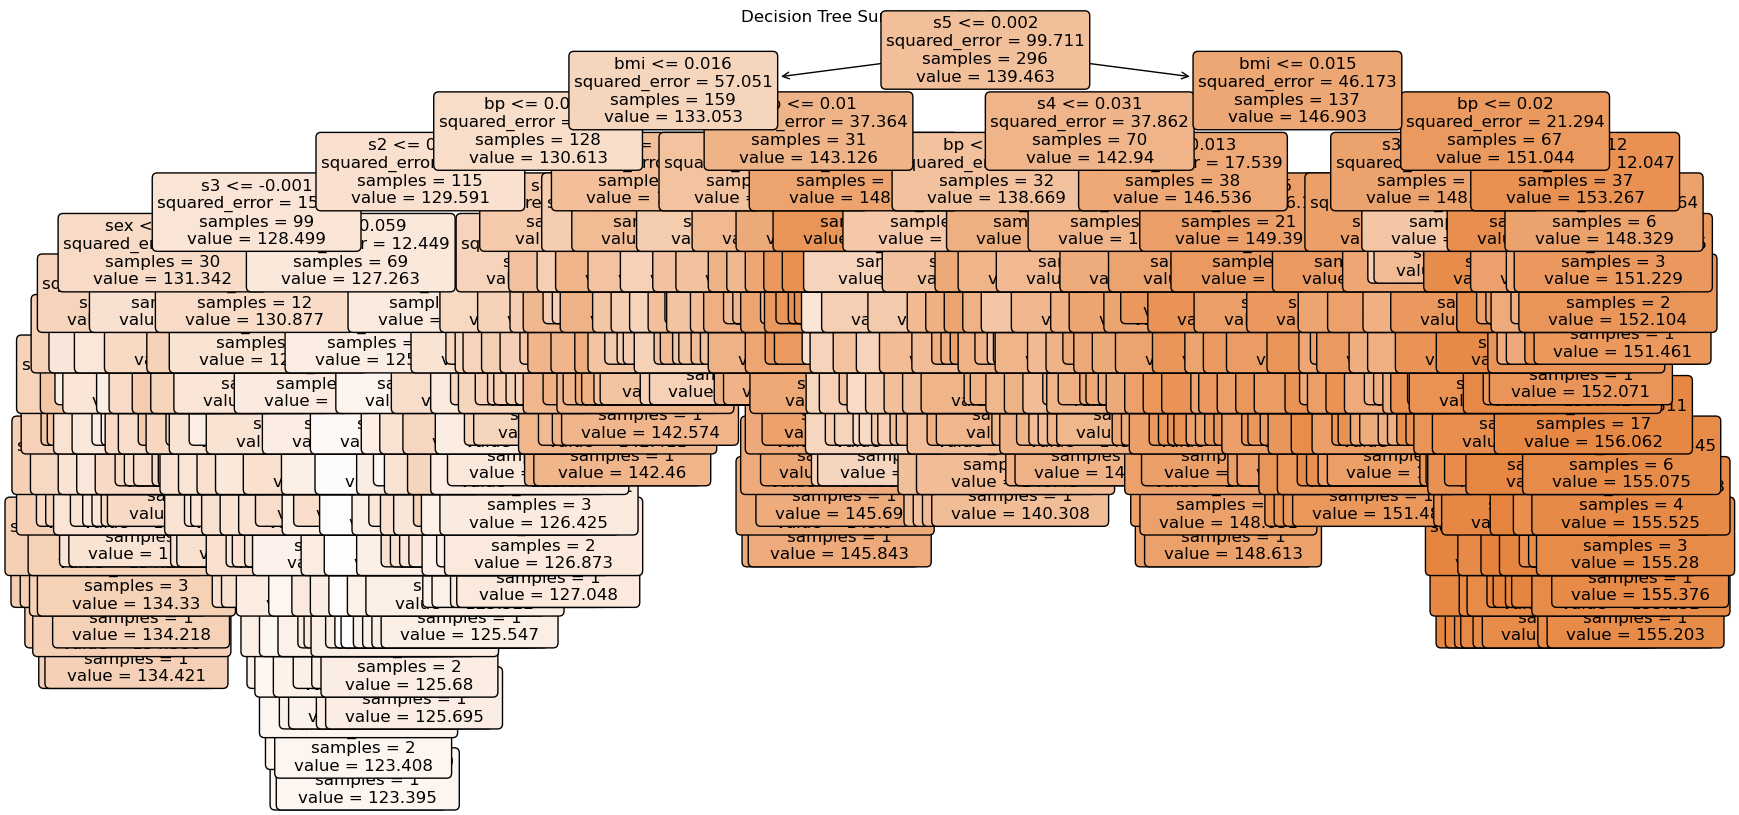

In [20]:
#Visualize the tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(surrogate, filled=True, feature_names=data['feature_names'], rounded=True, fontsize=12)
plt.title('Decision Tree Surrogate of SVR')
plt.show()


* How is the SVM approximated?
* What features give the most importance to the model?
* How does it operate?

In [ ]:
#SVM is approximated by a dt. But this time there are too many nodes in it for the model to be interpretable.
#In this case the dt is not a good surrogate model, and it is difficult to tell which features are important.
#However, the basic principle behind using a decision tree as a surrogate model to approximate an SVR remains the same.

**To be filled by student**

# Final reflections

Reflect about your laboration. This includes but is not limited to the example points below.

* How does the feature permutation give us insight to explain the model?
* What conclusions can you draw from it?
* The Global surrogate model takes another approach to explain the model. Is it useful?
* How can you use the surrogate to explain your model?


**to be filled by student**
Feature permutation and surrogate modeling are two techniques used to gain insights into machine learning models, particularly those considered "black boxes" like SVMs or deep neural networks. Feature permutation assesses the importance of each feature by measuring the decrease in model performance (e.g., accuracy, r2 score) when the values of that feature are randomly shuffled. This process highlights how dependent the model is on specific features for making predictions. A global surrogate model, like a decision tree approximating an SVR, attempts to mimic the entire prediction function of the original model. This approach provides a more transparent model that can be analyzed and interpreted directly, on paper. In the case of the SVR, it was very difficult to give any meaningful explanation for the predictions with it.

In summary, feature permutation highlights the dependency on specific features, while surrogate models offer an interpretable approximation of the model's decision-making process. Both methods have their place for model interpretation and explanation.